In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import h5py
from astropy.table import Table
from astropy.constants import R_sun, R_earth
from glob import glob

X = []
labels = []

for lcpath, truthpath in zip(sorted(glob('../data/parallel_normed/*_simulated_transit_lcs.npy')), 
                             sorted(glob('../data/parallel_normed/*_simulated_spots_occulted.npy'))):
#     print(np.shape(np.load(lcpath).T))
    X.append(np.load(lcpath).T)
    labels.append(np.load(truthpath))

X = np.concatenate(X)[:, :, np.newaxis]# - np.array(X).mean()
X -= X.mean()
X /= X.ptp()
# X += 0.5
labels = np.hstack(labels)#[:, np.newaxis]

train_X = X
train_Y = labels

# print('Training data shape : ', train_X.shape, train_Y.shape)

from keras.utils import to_categorical

train_Y_one_hot = to_categorical(train_Y)
# test_Y_one_hot = to_categorical(test_Y)

from sklearn.model_selection import train_test_split

train_X, valid_X, train_label, valid_label = train_test_split(train_X, train_Y_one_hot, 
                                                              test_size=0.2, random_state=13)

Using TensorFlow backend.
/Users/bmmorris/anaconda/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: compiletime version 3.6 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.5
  return f(*args, **kwds)


In [40]:
from keras.models import load_model
import matplotlib.ticker as ticker
from sklearn.metrics import precision_recall_curve

paths = ['../data/model.hdf5'] + glob('data/model?.hdf5')

precisions = []
recalls = []

for path in paths: 
    model = load_model(path)
    predict_y = model.predict(valid_X)
    precision, recall, thresh = precision_recall_curve(valid_label[:, 0] == 1, predict_y[:, 0])

    precisions.append(precision)
    recalls.append(recall)
    del model

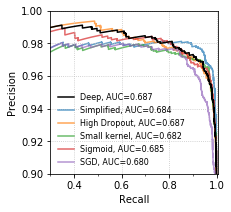

In [56]:
plt.figure(figsize=(3, 3))

labels = ['Deep', 'Shallow', 'Simplified', 'High Dropout', 'Small kernel', 'Sigmoid', 'SGD']

recall_thresh = 0.3

for i, recall, precision, label in zip(range(len(recalls)), recalls, precisions, labels):
    # Skip shallow
    if label != 'Shallow':
        sort = np.argsort(recall)
        recall = recall[sort]
        precision = precision[sort]

        auc = np.trapz(precision[recall > recall_thresh], 
                       recall[recall > recall_thresh])

        plt.plot(recall, precision, label=label+", AUC={0:.3f}".format(auc),
                 alpha=0.7 if i != 0 else 1, color=None if i != 0 else 'k', 
                 zorder=0 if i != 0 else 10)

plt.xlim([0.3, 1.005])
plt.ylim([0.9, 1.00])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(loc='lower left', fontsize=8, facecolor='none', frameon=False)    
plt.grid(ls=':', color='silver')
plt.gca().xaxis.set_minor_locator(ticker.MultipleLocator(0.1))
plt.savefig('../plots/precision_recall.pdf', bbox_inches='tight')